# Output File Analysis - Multiple SRRs - Donor to Recipient Workflows

## Variables

In [4]:
## Variables
srr_names <- c("SRR5090597", "SRR5090599", "SRR5090601", "SRR5090603", 
               "SRR5090605", "SRR5090607", "SRR5090609", "SRR5090611", 
               "SRR5090613", "SRR5090615", "SRR5090617", "SRR5090619")
donor_name <- "hpv16"
recipient_name <- "UCSChg38"
inputs_folder <- "../../wallaby/workflows/final-outputs-hpv16-rnaseq"
donor_ref_genome <- "../../wallaby/data/ref_genomes/hpv/HPV16.fa"
recipient_ref_genome <- "../../wallaby/data/ref_genomes/human/hg38.fa"

## Import Libraries

In [5]:
## Setup Environment
# Enable multithreading when possible (library dependent)
options(Ncpus = parallel::detectCores())
Sys.setenv(OMP_NUM_THREADS=toString(parallel::detectCores()))
Sys.setenv(OMP_THREAD_LIMIT=toString(parallel::detectCores()))
Sys.setenv(OMP_NUM_THREADS=parallel::detectCores())
Sys.setenv(OMP_THREAD_LIMIT=parallel::detectCores())

## Load or install and load all libraries
suppressPackageStartupMessages(library("pacman", character.only = TRUE))

# List of CRAN packages to either Load, or Install and Load
pacman::p_load(dplyr, ggplot2, shiny, shinyLP, DT,  ggrepel,  tidyr, IRdisplay, repr, stringr,
               data.table, kableExtra, knitr, IRdisplay, install = FALSE)

# List of Bioconductor packages to either Load, or Install and Load
pacman::p_load(BSgenome, BSgenome.Hsapiens.UCSC.hg38, GenomicFeatures, 
               GenomicAlignments,  Rsubread,  Rsamtools, bamsignals,  
               rtracklayer, GenomicRanges, org.Hs.eg.db, Organism.dplyr,
               TxDb.Hsapiens.UCSC.hg38.knownGene, regioneR, karyoploteR,
               seqinr, Repitools, Gviz, Biostrings, install = FALSE)

## Load Files for Analysis

In [6]:
# Select crossings to import and order of visualization
crossings <- c("UMd_MMr", "MUd_MMr", "UMd_MUr", "MUd_UMr", "MMd_UMr", "MMd_MUr")

In [7]:
# Load all .bed files for all srrs created by the cromwell workflow

# Define variables to hold all srrs
recip_granges_all_srrs <- list()

# Loop over each srr
for (srr in srr_names) {
    
    # For each single srr
    recip_granges <- list()
    recip_granges_crossings <- list()

    # Load all .bed files created by the cromwell workflow
    for (cross in crossings){
        # list all recipient files
        recip_file <- list.files(inputs_folder,
                                  pattern=paste(srr, 
                                                '-to-',
                                                recipient_name,
                                                "_", cross, 
                                                ".bed", 
                                                sep = ""), 
                                  recursive = TRUE, 
                                  full.names = TRUE)

        # check whether the file exists and add if it does
        if (!identical(recip_file, character(0))) {
            recip_granges[[cross]] <- import(recip_file)
            recip_granges_crossings[[cross]] <- cross
        }
        
        # add recip_granges for this srr to the _all object
        recip_granges_all_srrs[[srr]] <- recip_granges
    }
}

In [8]:
# Load recipient .bam files created by the cromwell workflow

# Define variables to hold all srrs
recip_bams_all_srrs <- list()

# Loop over each srr
for (srr in srr_names) {
    
    recip_bams <- list()
    recip_bam_crossings <- list()

    for (cross in crossings){
        # list all donor files
        recip_file <- list.files(inputs_folder,
                                  pattern=paste(srr, 
                                                '-to-',
                                                recipient_name,
                                                "_", cross, 
                                                ".bam$", 
                                                sep = ""), 
                                  recursive = TRUE, 
                                  full.names = TRUE)

        # check whether they exist and add if they do
        if (!identical(recip_file, character(0))) {
            recip_bams[[length(recip_bams) + 1]] <- recip_file
            recip_bam_crossings[[length(recip_bam_crossings) + 1]] <- cross
        }
        
        # add recip_granges for this srr to the _all object
        recip_bams_all_srrs[[srr]] <- recip_bams
    }
}

## Helper Functions

In [9]:
# Create a sqlite database from TxDb and corresponding Org packages
# The database provides a convenient way to map between gene, transcript, and protein identifiers.
src <- suppressMessages(suppressWarnings(src_organism("TxDb.Hsapiens.UCSC.hg38.knownGene")))
# Create a full genome sequences for Homo sapiens (Human) as provided by UCSC (hg38, based on GRCh38.p12)
Hsapiens <- BSgenome.Hsapiens.UCSC.hg38

In [10]:
# Function to Create a Table mapping ranges of overlapping paired-end crossings 
summary_table_recipient <- function(granges, 
                                    granges_labels, 
                                    min_num_crossings = 3,
                                    min_num_reads = 3, 
                                    src,
                                    Hsapiens) {
    
    # convert all granges to dataframes
    granges_df <- lapply(granges, annoGR2DF)
    # assign all granges labels (crossing names) as each dataframe's name
    names(granges_df) <- granges_labels
    # flatten all dataframes into a single dataframe, 
    # and use their's respective name as an identifier in a new column named 'crossing'
    merged_df <- bind_rows(granges_df, .id = "crossing")
    # convert the data.frame to a data.table
    merged_dt <- as.data.table(merged_df)

    # assign each row to a group, based on whether their ranges overlap
    merged_dt[,group := { ir <- IRanges(start, end); subjectHits(findOverlaps(ir, reduce(ir))) }, by = chr]
    # aggregate results by group, and add additional aggregated columns
    merged_final <- merged_dt[, list(start = min(start), 
                                     stop = max(end), 
                                     num_crossings = length(unique(list(crossing)[[1]])),
                                     unique_crossings = list(unique(crossing)),
                                     num_reads = length(list(name)[[1]])
                                     ), by = list(group, chr)]
    
    # filter results using a minimum number of reads and/or crossings
    merged_final <- merged_final[merged_final[, num_reads > (min_num_reads - 1)]]
    merged_final <- merged_final[merged_final[, num_crossings > (min_num_crossings - 1)]]
    
    # there might be no matches, so check for that before looking for a gene name
    if (nrow(merged_final) != 0) {
        # use the src database to look for the gene names or each crossing overlap region
        # then, add it as a new column
        merged_final$gene_name <- apply(merged_final, 1, FUN = function(x) toString(
            unique(unlist(suppressWarnings(annoGR2DF(
                                    transcripts(src, 
                                                 filter=~(GRangesFilter(
                                                     GenomicRanges::GRanges(
                                                         paste(toString(x["chr"]), ":", 
                                                               as.integer(x["start"]), "-", 
                                                               as.integer(x["stop"]), sep = "")))), 
                                                 columns=c("symbol")))$symbol)))))
                                        
        # use the Hsapiens databse to look up the DNA sequence for each crossing overlap region
        # then, add it as a new column
        merged_final$sequence <- apply(merged_final, 1, FUN = function(x) toString(getSeq(Hsapiens, 
                                                                           toString(x["chr"]), 
                                                                           start = as.integer(x["start"]), 
                                                                           end = as.integer(x["stop"]))))
        # delete the 'group' column
        merged_final <- merged_final[, !"group"]
        # add an ID to each row
        merged_final <- merged_final[, id := .I]
        setcolorder(merged_final, c("id", "chr", "start", "stop", 
                                    "num_crossings", "unique_crossings", 
                                    "num_reads", "gene_name", "sequence"))
                                       
    # if there are no matches, write an NA row
    } else {
            return(data.table(id = "<NA>",
                              chr = "<NA>", 
                              start = 0, 
                              stop = 0, 
                              num_crossings = 0, 
                              unique_crossings = "<NA>", 
                              num_reads = 0, 
                              gene_name = "<NA>", 
                              sequence = "<NA>")
                  )
        }

    return(merged_final)
}

In [11]:
# Function to Create a Summary Table for many SRRs
srrs_summary_table_recipient <- function(granges_list, 
                                         min_num_crossings,
                                         min_num_reads, 
                                         src,
                                         Hsapiens) {

    # store all tables in a single list
    srrs_list <- list()
    
    # iterate over all granges
    for (srr in names(granges_list)) {

        # create a summary table for each granges object
        granges <- unname(granges_list[srr][[1]])
        granges_labels <- str_split(names(granges_list[srr][[1]]), " ")
        summary_table <- summary_table_recipient (granges = granges,
                                                  granges_labels = granges_labels,
                                                  min_num_crossings = 1, 
                                                  min_num_reads = min_num_reads, 
                                                  src = src, 
                                                  Hsapiens = Hsapiens)
        
        # add a column for the srr
        summary_table$srr <- srr
        # add the table to the list
        srrs_list[[srr]] <- summary_table
    }
    
    # bind all the tables by row
    srrs_summary_table <- do.call(rbind, c(srrs_list, fill=TRUE))
    # reorder the table
    setcolorder(srrs_summary_table, c("srr", "id", "chr", "start", "stop", 
                                      "num_crossings", "unique_crossings", 
                                      "num_reads", "gene_name", "sequence"))

    # stylize the output
    srrs_summary_table %>%
        kable("html") %>%
        kable_styling(bootstrap_options = "striped", full_width = F, position = "left") %>%
        column_spec(10, width = "30em", width_max = "30em") %>%
        as.character() %>%
        display_html()
    
    return (srrs_summary_table)
}

In [12]:
# Function to create a visualization for specific overlap regions
plot_reads_region <- function(srr, id = 1, crossings_table_recipient, recip_bams, extend_left = 20, extend_right = 20, ref_genome) {
    
    # extend the graph to the left and right by this margin
    extend_left <- 20
    extend_right <- 20
    
    # extract chromosome, start, and end positions from the given overlap table
    chr <- toString(crossings_table_recipient[id,]$chr)
    start <- toString(crossings_table_recipient[id,]$start - extend_left) 
    end <- toString(crossings_table_recipient[id,]$stop + extend_right)
    crossings <- as.list(strsplit(crossings_table_recipient[id,]$unique_crossings[[1]], ","))
    gene_name <- toString(crossings_table_recipient[id,]$gene_name)
    graph_title <- paste("SRR: ", srr, "  -  ",
                         "ID: ", toString(crossings_table_recipient[id,]$id), "  -  ",
                         "Num Reads: ", toString(crossings_table_recipient[id,]$num_reads), "  -  ",
                         "Gene Name(s): ", if (gene_name == "") "No Match" else gene_name)
    
    # only shows bams with overlaps
    bams <- list()
    for (crossing in crossings) {
        bams <- c(bams, recip_bams[grepl(crossing, recip_bams, fixed = TRUE)])
    }
    
    # create a track which holds a schematic display of a chromosome
    i_track <- IdeogramTrack(genome = "hg38", chromosome = chr, from = as.numeric(start) - extend_left, cex = 3, cex.bands = 1,
                             to = as.numeric(end) + extend_right, showId = TRUE,  showBandId = TRUE)
    
    # create a track which display the genomics axis
    g_track <- GenomeAxisTrack(showId = TRUE, labelPos = "alternating", cex = 2)
    
    # create a track which holds genes and exons names
    gr_track <- GeneRegionTrack(TxDb.Hsapiens.UCSC.hg38.knownGene, genome = 'hg38', exonAnnotation = 'transcript',
                           chromosome = chr, name = "Genes/Exons", background.title = "red", fill = "orange",
                           transcriptAnnotation='gene', showID = TRUE, geneSymbol = TRUE, showExonId = TRUE)
    
    # create a track which holds the reads, coloring mismatches and indels
    a_tracks <- mapply(function(x, y) { AlignmentsTrack(x, name = y, isPaired = TRUE, stacking = 'full',  
                                                        chromosome = chr, min.height = 0.01, max.height = 10, 
                                                        background.title = "blue", fill="black", alpha = 0.90,
                                                        type = "pileup", showMismatches = TRUE, alpha.mismatch = 1,
                                                        showIndels = TRUE, col.mates = "purple")
                                      }, bams, crossings)
    
    # create a track which holds each letter
    s_track <- SequenceTrack(readDNAStringSet(recipient_ref_genome), chromosome = chr, min.width = 0.1, cex = 0.5)
    
    # plot all tracks together
    plotTracks(c(i_track, g_track, gr_track, a_tracks, s_track), chromosome = chr, col.main = "black",
               from = as.numeric(start), to = as.numeric(end), main = graph_title,
               extend.left = extend_left, extend.right = extend_right, just.group = 'above', cex.title = 2, rotation.title = 0, 
               title.width = 8, sizes = c(0.5, 0.7, 0.5, replicate(length(crossings), 1), 0.2))
}

## Recipient Analysis

In [13]:
# Aggregated view of all overlapping crossings for the potential recipient for all srrs
srrs_summary_table <- srrs_summary_table_recipient (granges_list = recip_granges_all_srrs, 
                                                    min_num_crossings = 2,
                                                    min_num_reads = 7, 
                                                    src = src,
                                                    Hsapiens = Hsapiens)

srr,id,chr,start,stop,num_crossings,unique_crossings,num_reads,gene_name,sequence
SRR5090597,1,chr1,150576896,150577494,6,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr, MMd_UMr, MMd_MUr",386,MCL1,GCTTCCCTTGTACAGTACTGAGGCTTACAGTCATAGTTCTATTACTTGTAACTTTTACACAGGTCACTGGCATTCTTAGTGCTTCTCTTAACACTACAGTAAATTAATGAATTCGGCGGGTAATCAATTCTATGACTTGCCTGGCTACTGGCCACTTTCCTGTTCTCAACAAGGAAATTAAGTCTTTCCACCCTACCATCTTCACTAAATCTAAAAGTCCTCCTCCATAGCTTCCCAAACAAAGTTTGTTTGTTGCTGAAACTGAACTTTGCTTCTTTCAGACAGTGACTCTTCAATCAATGGGGAGCACTCTTCCCATGTATTTATTCTTGTTAGCCATAATCCTCTTGCCACTTGCTTTTCTGGCTAGGTTGCTAGGGTGCAACTCTAGGAAGTTACAGCTTGGAGTCCAACTGCATAAACTGGTTTTGGTGGTGGTGGTGGTTGGTTAAAAGTCAACTATTGCACTTACAGTAAGGCTATCTTATTAGATATGCCAAACCAGCTCCTACTCCAGCAACACCTGCAAAAGCCAGCAGCACATTCCTGATGCCACCTTCTAGGTCCTCTACATGGAAGAACTCCACAAACCCATCCTA
SRR5090597,2,chr1,150578243,150578495,6,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr, MMd_UMr, MMd_MUr",528,MCL1,CCCAGCCTCTTTGTTTAACTAGCCAGTCCCGTTTTGTCCTTACGAGAACGTCTGTGATACTTTCTGCTAATGGTTCGATGCAGCTTTCTTGGTTTATGGTCTTCAAGTGTTTAGCCACAAAGGCACCAAAAGAAATGAGAGTCACAATCCTGCCCCAGTTTGTTACGCCGTCGCTGAAAACATGGATCATCACTCGAGACAACGATTTCACATCGTCTTCGTTTTTGATGTCCAGTTTCCGAAGCATGCCTGA
SRR5090599,1,chr1,206939232,206939466,4,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr",22,PIGR,GTGCCGTTCTCCGGGAAGTTGGTGAGGTTAGCCCTGCCTGCATATTTGCTGGAGACGTAGCCCTCCGAGGAGATGAGGGTTATGCAGCCACCTCTAGCTCCCTGCCGGCACCAGTACTTCCGGGTGTGCCGGTTGACAGAGGTGGGTGGGTAGTAGCACGTGATGGACACTGAGTTACCTTCCACACTATTCACCTCCTCGGGACCAAATATGGGACTCTTCGTGGAGATGGCTG
SRR5090599,2,chr1,206940489,206940589,6,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr, MMd_UMr, MMd_MUr",36,PIGR,CTGGGAAGACCGCCAGCAGGCAGGTGAGCACGAAGAGCAGCATTGCTGGTGGGTCCCGAGCGCCGCACCACTCAGGCCGACTTCTCCTGTGCAATGCTGAA
SRR5090599,3,chr1,206949933,206950244,6,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr, MMd_UMr, MMd_MUr",54,,GGCCACCCTCCAGGCTCTAGACGATAATCCGTTGCTTGCCTCTTCTAGCTTCTGGTTGCTGCTGACATTCTTTGGTGTTCTTTGGCACGTAGCTGTGTCACTCCAACCTCTGCCTTCATAGTCACATTGGCTTCTGTGTATGTCTCAAATAACTCTCTGTTTCTCTGTTATATGGATGGTATTTAGGGCCCACCCAGCTAATCCAAGATGATGTCCTCATCTCAAGATCCTGAACTTCATCACATCTACAAAGACTCTTTTCCAAATAAGGTCACACTTCTGGGCTCCAGAGATTGAGACATAGACAAACCT
SRR5090601,1,chr4,138677977,138678231,2,"UMd_MMr, MUd_MMr",7,,GGTGTTAGCAATGAGGCTATATGCACTTGCTTGTACAACAGCAGATTGGCTGCTGTTTCTGTCACTCTGAGAGACCAACATTAAGGCTCAAATTAACTAGCAAGTGTAAACCACAGGAACCAAGAGAATGATTTCACAGACTTATTTTTTTCTCCTCTCTATTTGTATAATTTTAGCAACTAGGGCATGAAGTGTGCAGGGCCCAGTGTCAGTGTGGTGGAAGCAGCAGGGGAATGATGAGTTGATGAGCTTGGG
SRR5090601,2,chr4,138678739,138678935,2,"UMd_MMr, MUd_MMr",13,,GCAGATGCTAATGAGGAGTGACATCACCAAGATGCAGTAGCAGAGGGGCATGGTGAGAAACAAGAGGGCTTGGTGGGATATAATGGAAAAACTACGTTAATACCAGGGGACTAAATGTGCAAGGCAGCCCTGCTGTGTGGCAGTGCGACGGTCAAGCCCCACCAGAAACAAACAAACAAAAATCACCTCTCTGTTGG
SRR5090601,3,chr4,138685416,138685761,2,"UMd_MMr, MUd_MMr",122,,AGATTAACTGTATCTTGAGAGTTGGCCAGGAGTAAGAAGAGTGTTTGGAAGGAAGAGAAGGTGGAAAATGAAGAGGCGGCAAGAGACTCAGGCAATCAGACAAACAAATCATCCATCTTCCCGGCTGAGGTCAGGAATATTCGAAAAGCCCTGTGTCCTGCACAGCAGCCCCACGCAGGTTTAGTGCAGCAGATGCTCTCTGGCTGAGTTAGAGAAACAGACAAAACCCTCATTTCTCTCTGAGCACTAAGTACAGAAGATGAGGCTGCGTCAGTCTCATTAGGAATAATAGACAGAAATTGCTTACAATCATCTCTAATGGGTTGCCAGTTTTCTGACAATGGGC
SRR5090603,1,chr20,33707709,33707974,4,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr",29,PXMP4,ATTGGAGGGACGGCTCTTGTTATAGACGAGGAAGTCTGAGATGTCGTGCCATACATTGCTGTCCTCATAGAGGTAGGTCATGGAGGACTGCAGCGAGGGCTGCAGGGTGGATCGGTGATACTCAAAGAGCCACAGCACCAGCCCCCACACCACCGCAGTGAGCAGCGGGAACGGGTCCCACCTGGGTTCAGGGATGTAGCCCTTCTCTACAGCCAGGCGGCTCAGGGCAAACAGGACGCGTGACAACAGGTACATGTTGATCTGCA
SRR5090603,2,chr20,33710553,33710757,3,"UMd_MMr, UMd_MUr, MUd_UMr",51,PXMP4,ACCTGGCTGTTGATGTTATTGTTTTCTCCAAACACCAGGATACCCCCGAGGAAGGCCGCCAGGAATGCGTGTGCTGGGTAGGTCTTGCCTTGTATGTAGGACTGCAGGGCACGGAGACCCTTGTAGGTGAACACAAACCGTGCCAGGTTCCAGGAGTGGATATATGTGGCCTGCAGTATGGCCCACAGCTTCTCCTGGAGGCTGC


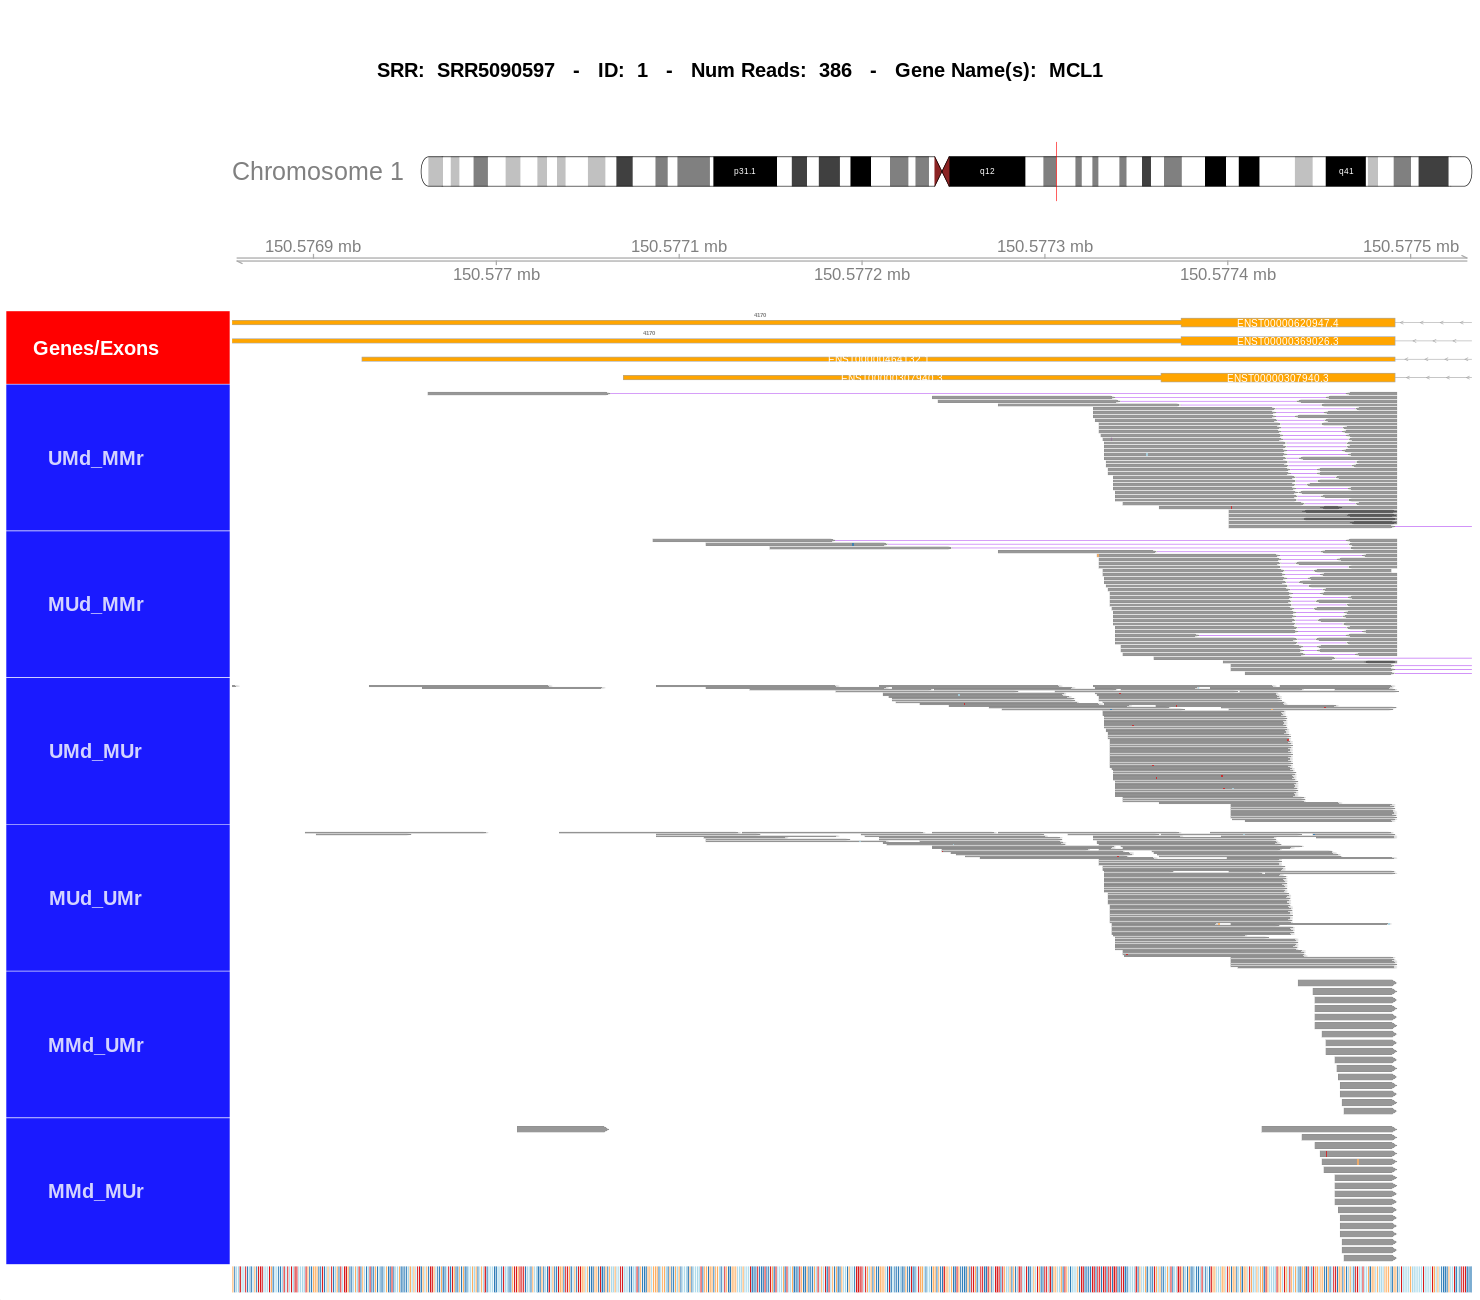

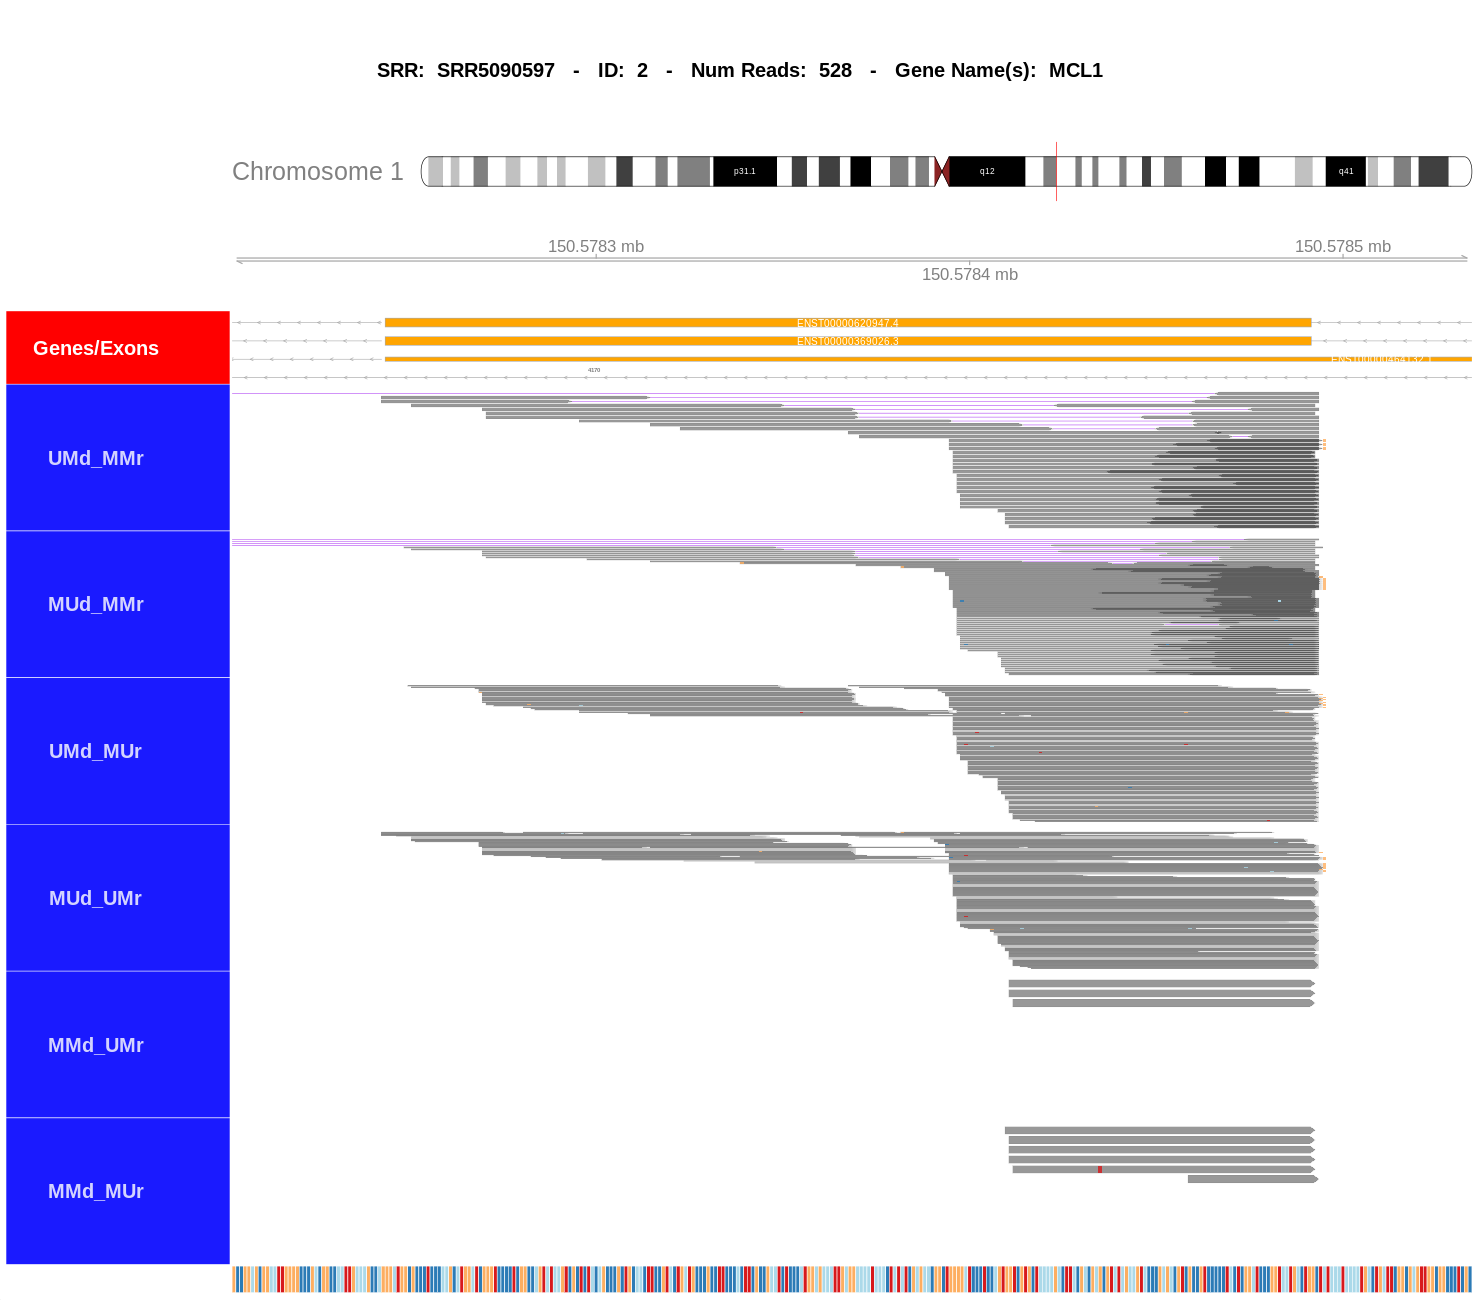

In [ ]:
# Plot all the overlapping reads for all 'ids' for all 'srr's

# delete all existing plots in the "plots" folder
was_deleted <- do.call(file.remove, list(list.files("./plots", full.names = TRUE)))

# extract all srrs
srrs <- as.list(unique(srrs_summary_table[,'srr']$srr))

# loop over all srrs
for (srr in srrs) {
    # extract table for srr
    crossings_table_recipient <- srrs_summary_table[srrs_summary_table[, srr == srrs[1]], ]
    crossings_table_recipient <- crossings_table_recipient[, !"srr"]
    
    # extract bams for srr
    recip_bams <- unlist(recip_bams_all_srrs[[srr]])
    
    # extract id list
    ids <- unlist(as.list(crossings_table_recipient[,"id"]$id))
    
    # create a visualization for all 'id's
    for (id in ids) {
        if (id != "<NA>") {
            # calculate height
            crossings_number <- length(as.list(strsplit(crossings_table_recipient[id == id,]$unique_crossings[[1]], ",")))
            height <- 400 + 150 * crossings_number

            # open image writer
            png(paste("./plots/plots_" , id, ".png", sep = ""), width = 1480, height = height, res = 60)
                # plot graph
                plot_reads_region(srr = srr,
                          id = as.integer(id), 
                          crossings_table_recipient = crossings_table_recipient, 
                          recip_bams = recip_bams,
                          extend_left = 20, 
                          extend_right = 20, 
                          ref_genome = recipient_ref_genome)
            dev.off()
            # display plot as image
            display_png(file=paste("./plots/plots_", id,".png", sep=""))      
        }
    }
}